# Prueba de streamlines

### TODO: hay que convertir las partes útiles del código en funciones de la clase correspondiente

Cambio al directorio de abajo.

No correr más de una vez porque se pierde la referencia

In [3]:
import os

notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')

os.chdir(base_dir)

print(os.getcwd())
print(base_dir)

C:\Users\chesp\Documents\Ingenieria Mecanica\Tesis\Modelos_Analiticos_de_Estelas
C:\Users\chesp\Documents\Ingenieria Mecanica\Tesis\Modelos_Analiticos_de_Estelas\jupyter_notebooks\..


Importo módulos necesarios

In [4]:
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

### Carga de datos de OpenFOAM en la isosuperficie
Esto habría que repetirlo para cada dirección de viento analizada

In [5]:
from load_txt_datos import cargar_datos

file = 'U_superficie_gondolas.Dir.45.00.U8.50.raw'
path = os.path.join(base_dir, 'Datos_Rawson_sin_Turbinas', file)
print(path)

x, y, z, u, v, w = cargar_datos('isosuperficie', path)

minx, maxx = x.min(), x.max()
miny, maxy = y.min(), y.max()

print(minx, maxx)
print(miny, maxy)

C:\Users\chesp\Documents\Ingenieria Mecanica\Tesis\Modelos_Analiticos_de_Estelas\jupyter_notebooks\..\Datos_Rawson_sin_Turbinas\U_superficie_gondolas.Dir.45.00.U8.50.raw
0.0 6492.0
0.0 6316.0


### Interpolación de los datos en una grilla regular con densidad definida y (posiblemente) dimensión menor a la isosuperficie de OF

In [6]:
from scipy.interpolate import griddata

# Definición del dominio y densidad de la grilla
npois = 100
npoiX, npoiY = npois, npois

meshXmin, meshXmax = 1000, 5500
meshYmin, meshYmax = 500, 5000

xg = np.linspace(meshXmin, meshXmax, npoiX)
yg = np.linspace(meshYmin, meshYmax, npoiY)

XG, YG = np.meshgrid(xg, yg)

# Interpolación de variables output de OF sobre la grilla regular
ZG = griddata((x, y), z, (XG, YG), method='linear')
UG = griddata((x, y), u, (XG, YG), method='linear')
VG = griddata((x, y), v, (XG, YG), method='linear')
WG = griddata((x, y), w, (XG, YG), method='linear')

# %timeit WG = griddata((x, y), w, (XG, YG), method='linear')
# %timeit WG = griddata((x, y), w, (XG, YG), method='cubic')

### Evaluación de diferentes interpoladores sobre la grilla regular

In [7]:
from scipy.interpolate import interp2d

# %timeit interp_u = interp2d(XG, YG, UG)
# interp_u = interp2d(XG, YG, UG)
# %timeit interp_u(2000, 2000)

# La forma siguiente tarda 4 órdenes de magnitud menos con 100*100 puntos
# y 5 órdenes para 200 puntos
%timeit interp_u2 = interp2d(xg, yg, UG, kind='linear')
interp_u2 = interp2d(xg, yg, UG)
%timeit interp_u2(2000, 2000)

327 µs ± 9.79 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
18.3 µs ± 575 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [8]:
from scipy.interpolate import RectBivariateSpline

# Esta forma tarda unas 6 veces menos en las evaluaciones, la definición tarda igual
%timeit interp_u2 = RectBivariateSpline(xg, yg, UG, kx=1, ky=1)
interp_u2 = RectBivariateSpline(xg, yg, UG)
%timeit interp_u2(2000, 2000)

301 µs ± 3.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.98 µs ± 19.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [9]:
# Definir interpoladores en base a la grilla regular
_interp_u = RectBivariateSpline(xg, yg, UG.T) # Atention! transposition needed to make it work properly
_interp_v = RectBivariateSpline(xg, yg, VG.T)
_interp_w = RectBivariateSpline(xg, yg, WG.T)
_interp_z = RectBivariateSpline(xg, yg, ZG.T)

### Funcione de cálculo de las streamlines 
(cuidado que no pertenece a una clase y entonces el primer parámetro no es self)

In [45]:
# 1er funcion definida ( la de ale + calculo de z_iso + dz y z_iso + dz_acum)
def _makeHalfStreamline(x0, y0, xmin, xmax, ymin, ymax, dr, sign):
    """
    Compute a streamline extending in one direction from the given point.
    """
    
    sx = []
    sy = []
    ss = []
    sdz = []
    sdz_i = []

    x = x0
    y = y0
    s = 0.
    dz = 0.
    dz_i = 0.



    while xmin < x < xmax and ymin < y < ymax:

        u = _interp_u(x, y).item()
        v = _interp_v(x, y).item()
        w = _interp_w(x, y).item()
        
        # TODO: integrar desplazamiento vertical
        scale = sign * (dr / np.sqrt(u**2 + v**2))
        scale2 = sign * (dr/np.sqrt(u**2 + v**2 + w**2))

        x += scale * u
        y += scale * v
        # Here we may compute the actual s in 3D and also integrate the \Delta z
        dz_i = scale2 * w
        dz += dz_i
        s += np.sqrt(scale**2 + dz_i**2)  # TODO: check this!!

        sx.append(x)
        sy.append(y)
        ss.append(s)
        sdz.append(dz)
        sdz_i.append(dz_i)    
    
    return sx, sy, ss, sdz, sdz_i




def _makeStreamline(x0, y0, xmin, xmax, ymin, ymax, dr):
    """
    Compute a streamline extending in both directions from the given point.
    """

    sx, sy, ss, sdz, sdz_i = _makeHalfStreamline(x0, y0, xmin, xmax, ymin, ymax, dr, 1) # forwards
    rx, ry, rs, rdz, rdz_i = _makeHalfStreamline(x0, y0, xmin, xmax, ymin, ymax, dr, -1) # backwards

    rx.reverse()
    ry.reverse()
    rs.reverse()
    rdz.reverse()
    rdz_i.reverse()
    
    return rx + [x0] + sx, ry + [y0] + sy, rs + [0.] + ss, rdz + [0.] + sdz, rdz_i + [0.] + sdz_i




# # 2da funcion intentamos empezar a acumular el dz desde el minimo de w en cada streamline
# def _makeHalfStreamline(x0, y0, xmin, xmax, ymin, ymax, dr, sign):
#     """
#     Compute a streamline extending in one direction from the given point.
#     """
    
#     sx = []
#     sy = []
#     sz = []


#     x = x0
#     y = y0
#     dz = 0.

#     while xmin < x < xmax and ymin < y < ymax:

#         u = _interp_u(x, y).item()
#         v = _interp_v(x, y).item()
#         w = _interp_w(x, y).item()
        
#         scale = sign * (dr / np.sqrt(u**2 + v**2 + w**2))

#         x += scale * u
#         y += scale * v
#         dz += scale * w
#         z = _interp_z(x, y).item() + dz
        
#         sx.append(x)
#         sy.append(y)
#         sz.append(z)    
    
#     return sx, sy, sz


# def _makeStreamline(x0, y0, xmin, xmax, ymin, ymax, dr):
#     """
#     Compute a streamline extending in both directions from the given point.
#     """

#     sx, sy, sz = _makeHalfStreamline(x0, y0, xmin, xmax, ymin, ymax, dr, 1) # forwards
#     rx, ry, rz = _makeHalfStreamline(x0, y0, xmin, xmax, ymin, ymax, dr, -1) # backwards

#     rx.reverse()
#     ry.reverse()
#     rz.reverse()
    
# #     Busqueda de Semilla para corregir desplazamiento en z
#     ssx = rx + [x0] + sx
#     ssy = ry + [y0] + sy
    
#     w_i = []
#     for x, y in zip(ssx, ssy):
#         w_i.append(_interp_w(x,y).item())
#     x_semilla = ssy[w_i.index(min(w_i))]
#     y_semilla = ssy[w_i.index(min(w_i))]
    
#     sx, sy, sz = _makeHalfStreamline(x_semilla, y_semilla, xmin, xmax, ymin, ymax, dr, 1) # forwards
#     rx, ry, rz = _makeHalfStreamline(x_semilla, y_semilla, xmin, xmax, ymin, ymax, dr, -1) # backwards

#     rx.reverse()
#     ry.reverse()
#     rz.reverse()
        
#     return rx + [x_semilla] + sx, ry + [y_semilla] + sy, rz + [_interp_z(x_semilla, y_semilla).item()] + sz, x_semilla, y_semilla

### Cómputo de varias streamlines

In [46]:
# %%timeit
# x0 = list(range(1100, 5000, 500)) 
# y0 = [4900] * len(x0)

# Locate nstream streamlines along the diagonal. For other base flow direction another diagonal may need to be used
nstream = 20 # cantidad de streamlines
x0 = np.linspace(meshXmax, meshXmin, nstream)
y0 = np.linspace(meshYmin, meshYmax, nstream)
# print(_interp_u([meshXmin] , [meshYmin]).item())

dr = 200

streamlines = [_makeStreamline(*xy, meshXmin - dr, meshXmax + dr,
                               meshYmin - dr, meshYmax + dr, dr) for xy in zip(x0, y0)]


### Ploteo de las streamlines
Los puntos rojos corresponden a las streamlines calculadas, líneas negras son las streamlines calculadas por matplotlib y el color del fondo es la altura del terreno.

<IPython.core.display.Javascript object>


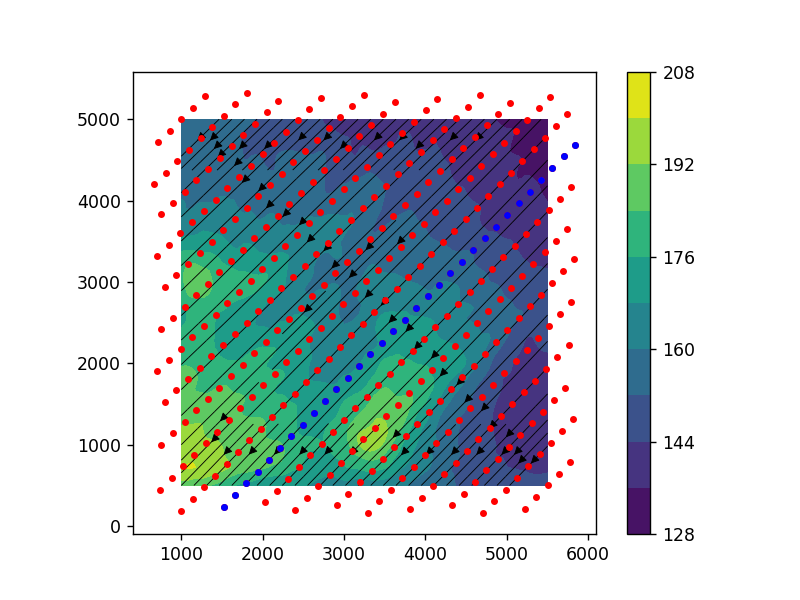

<IPython.core.display.Javascript object>


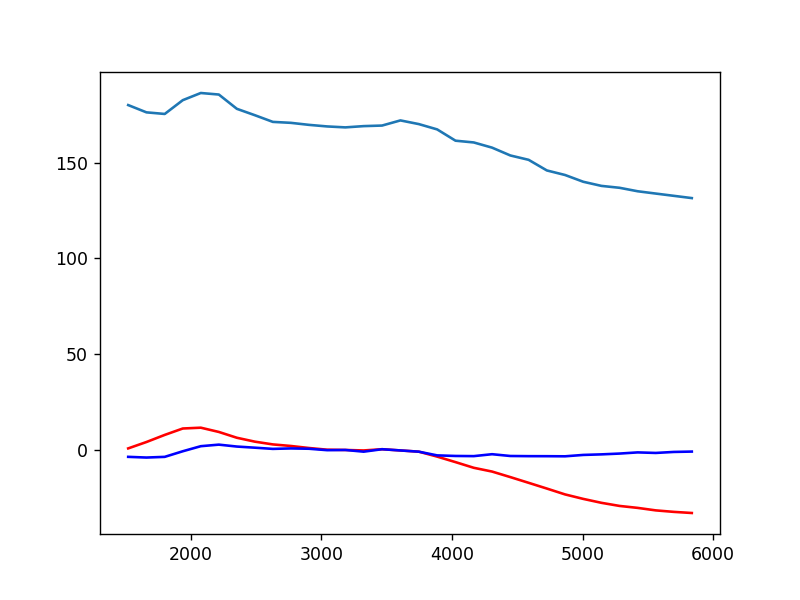

In [48]:
fig1 = plt.figure()
ax = fig1.add_subplot(1, 1, 1)

count = ax.contourf(XG, YG, ZG, 10)
# ax.plot(*streamline, '.')

for line in streamlines:
    ax.plot(line[0], line[1], '.r')

item = streamlines[8]
ax.plot(item[0], item[1], '.b')    

ax.streamplot(XG, YG, UG, VG, color='k', linewidth=.5)
fig1.colorbar(count)
ax.set_aspect('equal', 'box')

fig2 =plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)


# Para 1ra funcion mostramos la diferenciad de acumulado y sin acumular
ax2.plot(item[0], item[3], 'r')
ax2.plot(item[0], item[4], 'b')
z_iso = []
for x, y in zip(item[0], item[1]):
    z_iso.append(_interp_z(x, y).item())
ax2.plot(item[0], z_iso)


# # Para 2da funcion
# ax2.plot(item[0], item[2], 'r')
# z_iso = []
# for x, y in zip(item[0], item[1]):
#     z_iso.append(_interp_z(x, y).item())
# ax2.plot(item[0], z_iso)


[[157.34239978]]
[[143.16960367]]


<IPython.core.display.Javascript object>


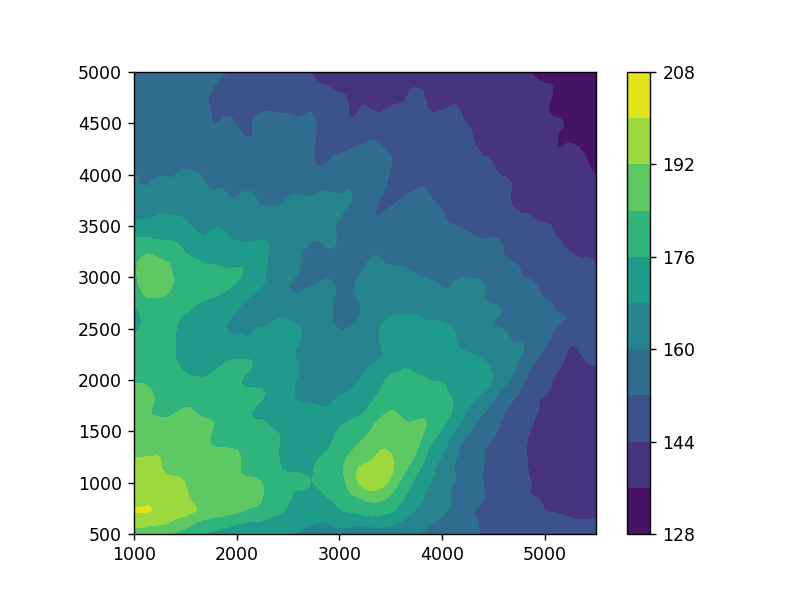

In [49]:
# # Checking z interpolation after trasposing ZG in the definition of _interp_z

print(_interp_z(1000, 5000))
print(_interp_z(5000, 1000))

fig1b = plt.figure()
ax1b = fig1b.add_subplot(1, 1, 1)

count1b = ax1b.contourf(XG, YG, _interp_z(XG, YG, grid=False), 10)
fig1b.colorbar(count1b)
ax1b.set_aspect('equal', 'box')

### Interpolar s, t y dz de las streamlines a la grilla regular


In [64]:
from math import sqrt

xs = []
ys = []
ss = []
ts = []
dzs = []

tscale = sqrt((meshXmax - meshXmin) ** 2 + (meshYmax - meshYmin) ** 2) / nstream
for enum, st in enumerate(streamlines):
    xs.extend(st[0])
    ys.extend(st[1])
    ss.extend(st[2])
    dzs.extend(st[3])
    print(len(st[0]))
    ts.extend([enum * tscale] * len(st[0]))
    print(ts)

5
[0.0, 0.0, 0.0, 0.0, 0.0]
9
[0.0, 0.0, 0.0, 0.0, 0.0, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634]
11
[0.0, 0.0, 0.0, 0.0, 0.0, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634, 636.3961030678927, 636.3961030678927, 636.3961030678927, 636.3961030678927, 636.3961030678927, 636.3961030678927, 636.3961030678927, 636.3961030678927, 636.3961030678927, 636.3961030678927, 636.3961030678927]
15
[0.0, 0.0, 0.0, 0.0, 0.0, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634, 318.19805153394634, 636.3961030678927, 636.3961030678927, 636.3961030678927, 636.3961030678927, 636.3961030678927, 636.3961030678927, 636.3961030678927, 636.

In [52]:
SG = griddata((xs, ys), ss, (XG, YG), method='cubic')
TG = griddata((xs, ys), ts, (XG, YG), method='cubic')
DZG = griddata((xs, ys), dzs, (XG, YG), method='cubic')

_interp_s = RectBivariateSpline(xg, yg, SG.T)
_interp_t = RectBivariateSpline(xg, yg, TG.T)
_interp_dz = RectBivariateSpline(xg, yg, DZG.T)

<IPython.core.display.Javascript object>


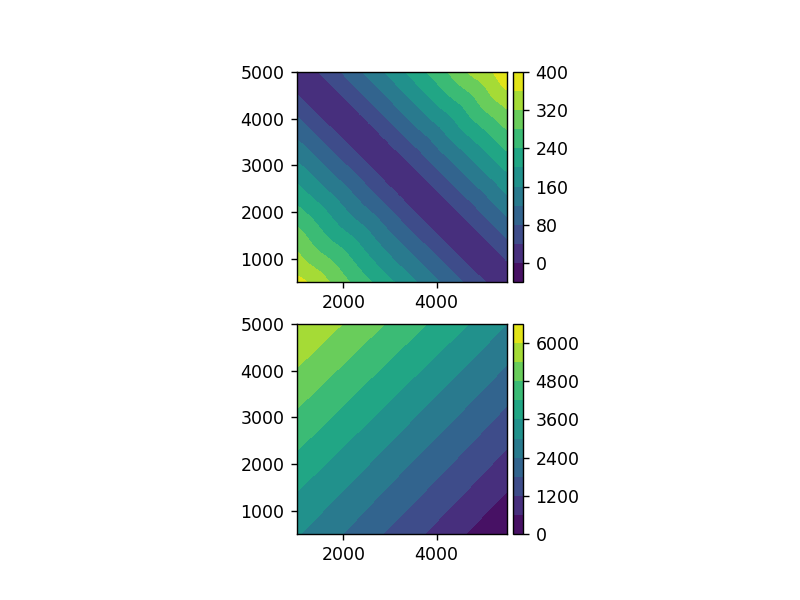

In [53]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig2 = plt.figure()
ax2 = fig2.add_subplot(2, 1, 1)
count2 = ax2.contourf(XG, YG, SG, 10)
ax2.set_aspect('equal', 'box')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig2.colorbar(count2, cax=cax, orientation='vertical')


ax2b = fig2.add_subplot(2, 1, 2)
count2b = ax2b.contourf(XG, YG, TG, 10)
ax2b.set_aspect('equal', 'box')
# fig2.colorbar(count2)

divider = make_axes_locatable(ax2b)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig2.colorbar(count2b, cax=cax, orientation='vertical')

In [31]:
# # Check t interpolation is equal to TG above

# fig4 = plt.figure()
# ax4 = fig4.add_subplot(1, 1, 1)

# count4 = ax4.contourf(XG, YG, _interp_t(XG, YG, grid=False), 10)
# fig4.colorbar(count4)

## Cálculos en cada evaluación del modelo de estelas

#### TODO: exponer solo las funciones necesarias en cada caso

In [61]:
%%timeit

# Wake maximum width
rmax = 500

# downstream turbine
T0 = (4000, 1500)

# Upstream turbines - list of tuples with corresponding x,y
Tup = [(3200, 4000), (3500, 3000)]

u0, v0 = _interp_u(*T0).item(), _interp_v(*T0).item()
muv = sqrt(u0 ** 2 + v0 ** 2)

nsamp = 21
samp_l = np.linspace(-1, 1, nsamp)

# TODO: filtrar para que x,y queden dentro del dominio
# El dominio debe permitir considerar estelas hasta rmax por fuera de la posición de las turbinas
samp_xy = (np.vstack((samp_l * rmax * -v0 / muv,
                      samp_l * rmax * u0 / muv)).T + T0).T

# print(samp_xy)
    
# print(_interp_s(*sampling, grid=False), _interp_t(*sampling, grid=False)) # grid=False interpreta los puntos sueltos y no como grilla 
# print(_interp_s(*T0, grid=False), _interp_t(*T0, grid=False))

88.4 µs ± 7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [58]:
from scipy.interpolate import interp1d

In [62]:
%%timeit
Tup_t = [_interp_t(*t, grid=False).item() for t in Tup]

# print(Tup_t)
# print(_interp_t(*samp_xy, grid=False))

# Descartar las turbinas fuera del rango de t del sampleo de acuerdo a rmax
Tup_l = interp1d(_interp_t(*samp_xy, grid=False), samp_l, kind='cubic', bounds_error=False)(Tup_t)
# Tup_l = Tup_l[~np.isnan(Tup_l)]
# print(Tup_l)

# Coordenadas de la línea de corriente de la turbina aguas arriba en el plano normal a la tubina considerada
stream_up_plane = (np.vstack((Tup_l * rmax * -v0 / muv,
                              Tup_l * rmax * u0 / muv)).T + T0).T

# print(stream_up_plane)

NameError: name 'Tup' is not defined

<IPython.core.display.Javascript object>


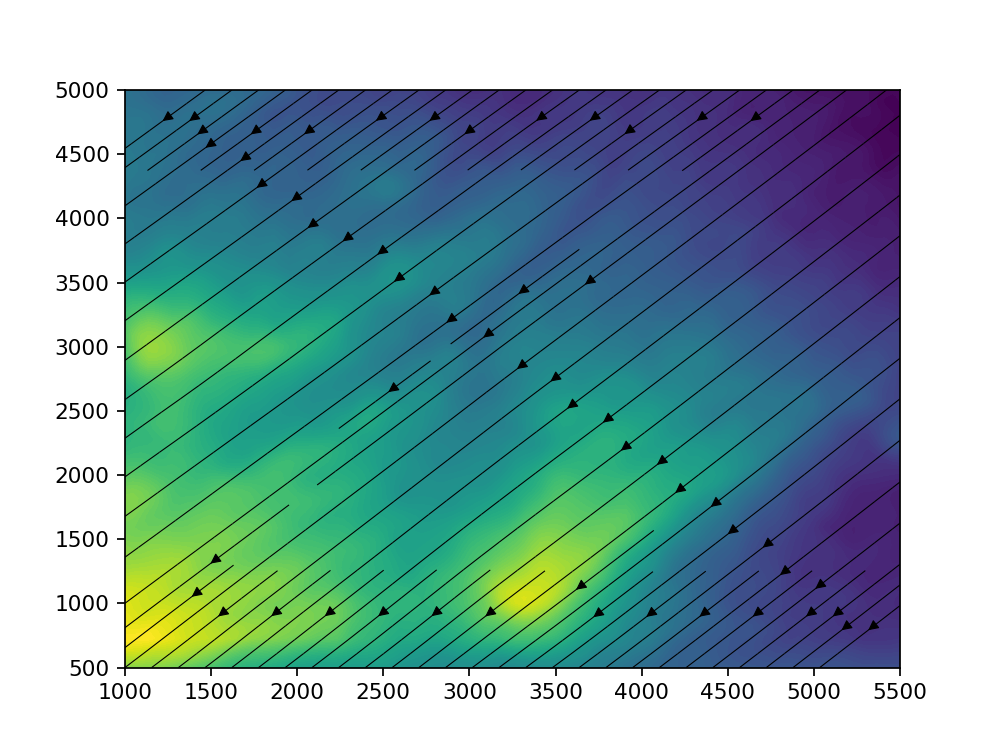

NameError: name 'samp_xy' is not defined

In [34]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(1, 1, 1)

count = ax3.contourf(XG, YG, ZG, 100)
# ax.plot(*streamline, '.')
ax3.streamplot(XG, YG, UG, VG, color='k', linewidth=.5)

ax3.plot(*samp_xy, '.g')
ax3.plot(*T0, 'xr')
for t in Tup:
    ax3.plot(*t, 'xb')
ax3.plot(*stream_up_plane, '*m')

ax3.set_aspect('equal', 'box')

In [44]:
%%timeit

hub_height = 80

# Posición del hub de T0
T0_hub = (T0[0], T0[1], _interp_z(*T0).item() + hub_height)
# print(T0_hub)

# Centro de las estelas aguas arriba
Tup_cl = [(stream_up_plane[0, ind], stream_up_plane[1, ind], 
           _interp_z(stream_up_plane[0, ind], stream_up_plane[1, ind]).item() 
           + _interp_dz(stream_up_plane[0, ind], stream_up_plane[1, ind]).item()
           - _interp_dz(Tup[ind][0], Tup[ind][1]).item()
           + hub_height) 
          for ind in range(len(Tup))
          if (~np.isnan(stream_up_plane[0, ind]) and ~np.isnan(stream_up_plane[1, ind]))]

# print(Tup_cl)

# Coordenada s desde T0 a las turbinas aguas abajo
sdiff = [_interp_s(T0[0], T0[1]).item() - _interp_s(Tup[ind][0], Tup[ind][1]).item()
         for ind in range(len(Tup))
         if (~np.isnan(stream_up_plane[0, ind]) and ~np.isnan(stream_up_plane[1, ind]))]

# print(sdiff)

47.3 µs ± 711 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
